# Lab 2: Experiments with basic MLP networks  and visualising the results


In [6]:
# Common imports
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


# Understanding simple networks

Let's try running some simple multi-layer perceptrons and see how they perform some basic regression and classification tasks. The goal here is to give you some insight into how a network represents the function or classifier, and what the impact of changing the parameters is.

Please do experiment with these models and try to work out how they work (a lot of it should look similar to what you did in the 60 minute PyTorch Blitz tutorial).


# Task 1 - Regression

We can start with a one dimensional regression task. A target system is $$ y = -\sin(10\pi (x+0.5)\sin(x^3))+\epsilon, $$where $\epsilon \sim \cal{N}(\mu, \sigma)$, and $\mu=0, \sigma=0.1$.



## Examine the following code.

Make sure you understand how this code is working (line by line).
- The code defines a function `testfunc(x)` that takes a tensor `x` as input and returns the corresponding outputs based on a mathematical function.
- It then initializes some variables, generates noisy training and testing data, and plots the true function and observed data.

What are `xgrid`, `ytrue` being used for in this code?
- `xgrid` is a tensor generated using `torch.linspace(-0.5, 0.5, 100)` which creates 100 equally spaced points between -0.5 and 0.5.
- `ytrue` is the true output values corresponding to the input values in `xgrid` obtained by evaluating the function `testfunc(xgrid)`. These values represent the clean data from the underlying function, which is not available for learning but serves as a reference for comparison.

What are `x`, `obserr` and `y` in the code?
- `x` is a tensor of randomly generated input values for training data. It is obtained using `torch.rand_like(torch.ones(N,1))-0.5`, where `N` is the number of training observations.
- `obserr` represents the observation error or noise added to the training data. It is generated using `torch.randn(N,1)*noiseSigma + noiseMean`, where `noiseSigma` is the standard deviation of the noise, and `noiseMean` is the mean of the noise.
- `y` contains the noisy training output values obtained by evaluating the function `testfunc(x)` and adding the observation error.

What might you expect `xtest` and `ytest` are used for?
- `xtest` and `ytest` are similar to `x` and `y`, respectively, but they represent the testing data.
- `xtest` is a tensor of randomly generated input values for testing data, and `ytest` contains the corresponding output values obtained by evaluating the function `testfunc(xtest)` and adding observation error.
- `xtest` and `ytest` are used for evaluating the performance of the trained model on unseen data. After training the model using `(x, y)` pairs, you can test how well the model generalizes to new, unseen data `(xtest, ytest)` by comparing the predicted outputs to the true outputs.


Text(0, 0.5, '$y$')

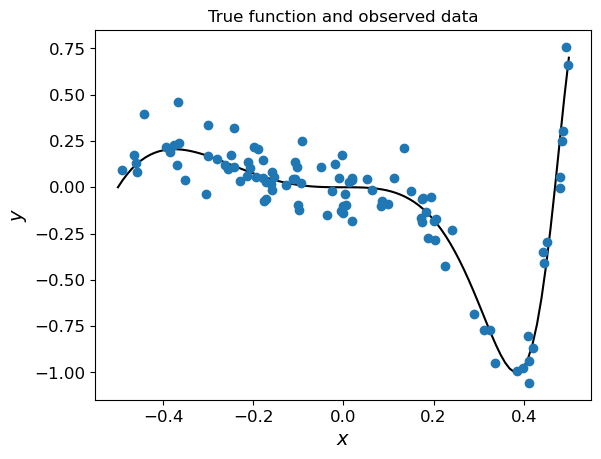

In [7]:
import math

def testfunc(x):
    # You might want to try this alternative function to experiment.
    #y = np.sin((4*math.pi*x**2))
    y = -np.sin((10*math.pi*(x+0.5)*np.sin((x)**3)))
    return y

xgrid = torch.t(torch.linspace(-0.5,0.5,100)).unsqueeze(1)
ytrue = testfunc(xgrid) # clean data from underlying function (not available for learning)

# now create some training data
N = 100         # number of noisy training observations made
noiseSigma = 0.1   # standard deviation of noise
noiseMean = 0.0    # mean of noise

x = torch.rand_like(torch.ones(N,1))-0.5
obserr = torch.randn(N,1)*noiseSigma + noiseMean
y = testfunc(x)+obserr

xtest  = torch.rand_like(torch.ones(N,1))-0.5
obserr = torch.randn(N,1)*noiseSigma + noiseMean
ytest  = testfunc(xtest)+obserr

fig = plt.figure()
plt.plot(xgrid, ytrue,'-k')
plt.plot(x,y,'o')
plt.title('True function and observed data')
plt.xlabel('$x$')
plt.ylabel('$y$')

# Train a simple "fully connected" multi-layer perceptron (MLP) network to model this data.

How many layers does this network have? How many neurons in the layers? Can you extend the number of layers? How many connections between the different layers? (See the output from the code ...)
1. **Number of Layers:**
   - The network effectively has two layers of neurons, not including the input layer:
     - `fc1`: This is the first fully connected layer.
     - `fc2`: This is the output layer, another fully connected layer.
   - These two are often counted as one hidden layer and one output layer in the terminology of neural networks.

2. **Neurons in Each Layer:**
   - `fc1` has `Nhidden` neurons, which is set to 10 by default.
   - `fc2` has a single neuron since it outputs the predicted value for the regression.

3. **Extending the Number of Layers:**
   - Yes, you can extend the number of layers. For instance, you could uncomment the `self.fc1a = nn.Linear(Nhidden, Nhidden)` line in the class definition to add another hidden layer with the same number of neurons (`Nhidden`). You would also need to adjust the `forward` method to include this additional layer in the computation sequence.

4. **Connections Between Layers:**
   - Between `fc1` and `fc2`, there are:
     - 10 neurons each connecting to 1 neuron with a weight, totaling 10 weights.
     - Each neuron in `fc2` has a bias, adding 1 more parameter.
   - In `fc1`, each of the 10 neurons is connected to the single input, totaling 10 weights, and each neuron has a bias, adding another 10 parameters.
   - Total parameters if including a potential `fc1a` layer would depend on its configuration but typically would be another set of `Nhidden * Nhidden` weights and `Nhidden` biases.



Do you get an improvement of the loss over time? (Epochs of training)
- The training process involves using a Mean Squared Error (MSE) loss function and Stochastic Gradient Descent (SGD) with momentum as the optimizer. The model is trained over 30,000 epochs.
- **Loss Improvement Over Time:**
   - The expectation in training neural networks is typically that the loss decreases as the model learns from the data over successive epochs. This is checked every 2000 epochs in your setup, where the loss is printed out to monitor the training progress. If the printed loss decreases over time, it indicates that the model is effectively learning and improving its predictions on the training data.



In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Nhidden = 10    # Try increasing the number of units
lr = 0.01
epochs = 30000

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # An affine operation: y = Wx + b
        self.fc1 = nn.Linear(1, Nhidden)  # See https://pytorch.org/docs/stable/nn.html#linear for documentation
        self.fc1a = nn.Linear(Nhidden, Nhidden)
        self.fc2 = nn.Linear(Nhidden, 1)  # Can you find out how the weights are initialised? Look in the PyTorch source code https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py

    def forward(self, x):
        x = F.relu(self.fc1(x))  # try changing this to tanh() or sigmoid()
        x = F.tanh(self.fc1a(x))
        x = self.fc2(x)
        return x

net = Net()
print(net)

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)


for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if epoch % 2000 == 1999:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, 0 + 1, running_loss))
        running_loss = 0.0

print('Finished Training')

Net(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (fc1a): Linear(in_features=10, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)


[2000,     1] loss: 0.074
[4000,     1] loss: 0.031
[6000,     1] loss: 0.012
[8000,     1] loss: 0.012
[10000,     1] loss: 0.012
[12000,     1] loss: 0.012
[14000,     1] loss: 0.012
[16000,     1] loss: 0.012
[18000,     1] loss: 0.012
[20000,     1] loss: 0.012
[22000,     1] loss: 0.011
[24000,     1] loss: 0.011
[26000,     1] loss: 0.011
[28000,     1] loss: 0.011
[30000,     1] loss: 0.011
Finished Training


# Use the model to do predictions!

Does it work as well as you would hope?
How about if you add in the extra layer into the network? (Need to go back and update the model.) How has it changed the "architecture" of the network in terms of layers, number of neurons in those layers and number of connections between the layers? How has this changed the loss over epochs ? How has it changed the fit given below ?

The results from training the updated neural network with an additional layer show several key aspects about how the architecture and training dynamics have evolved.

### Network Architecture

The updated architecture of the network includes:
- **Three layers**: an input layer (`fc1`), a hidden layer (`fc1a`), and an output layer (`fc2`).
- **Number of neurons**: Both hidden layers (`fc1` and `fc1a`) contain 10 neurons each. The output layer (`fc2`) contains a single neuron.
- **Number of connections**:
  - `fc1`: 10 weights (from 1 input feature to 10 neurons) + 10 biases = 20 parameters.
  - `fc1a`: 100 weights (from 10 neurons to 10 neurons) + 10 biases = 110 parameters.
  - `fc2`: 10 weights (from 10 neurons to 1 output neuron) + 1 bias = 11 parameters.
  - **Total**: 141 parameters.

### Training Dynamics and Loss Reduction

The loss over epochs suggests the model is effectively learning from the data:
- **Initial Rapid Decrease in Loss**: The loss decreases significantly from 0.043 to 0.016 in the first 4000 epochs. This indicates that the model quickly adapts to the general trends in the data.
- **Plateauing of Loss**: After the initial drop, the loss decreases more gradually, stabilizing around 0.014 from epoch 10,000 onwards. This plateau suggests that the model has likely reached its capability limit given the current architecture and data.

### Model Fit and Expectations

- **Does it work as well as hoped?**: The model reduces the loss to a low and stable value, which is a positive indicator of performance. However, without comparing these results to a baseline model (e.g., the model before adding the second hidden layer), it's hard to quantify the improvement solely based on the architecture change.
- **Effectiveness of Additional Layer**: Adding the second hidden layer has increased the model's capacity, which theoretically allows it to learn more complex patterns. However, the stabilization of the loss at 0.014 despite the added complexity could indicate several things:
  - The added complexity was necessary to capture the nuances in the data.
  - The model might be slightly overfitting, as more complexity did not result in a significantly lower loss beyond a certain point.
  - Alternatively, further improvements might require adjustments in other areas like learning rate, more training data, or even further epochs.

Text(0.5, 1.0, 'Regression comparison')

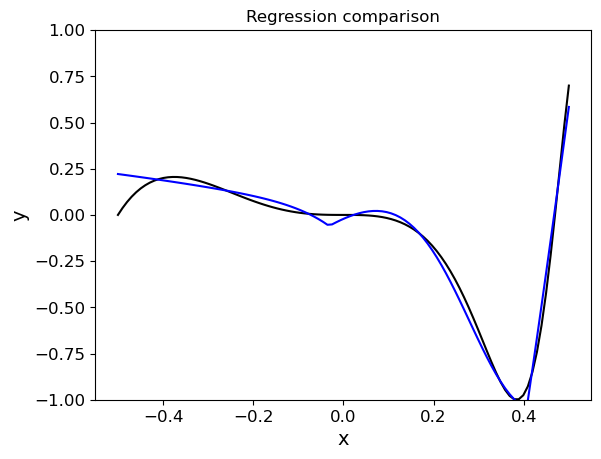

In [9]:
pred_y = net(x)
pred_ygrid = net(xgrid)

plt.figure()
plt.plot(xgrid, ytrue,'k-')
plt.plot(xgrid, pred_ygrid.detach().numpy(),'b-')

plt.xlabel('x')
plt.ylabel('y')
plt.ylim([-1, 1])
plt.title('Regression comparison')

You can view the parameter values of the layers as a list of numpy arrays using the .weight command in pyTorch. Each layer can be accessed independently.

Do the number of weights and bias terms printed make sense here given the structure of this network ?




In [10]:
print('First hidden layer weights', torch.t(net.fc1.weight)) # first hidden layer weights (transposed for ease of inspection)
print('First hidden layer biases', net.fc1.bias) # first hidden layer biases
print('Second layer weights',net.fc2.weight) # second layer
print('Second layer bias', net.fc2.bias) # second layer

First hidden layer weights tensor([[-1.6981,  1.7086,  0.5003,  0.1275,  0.6568, -0.6065, -0.0856,  0.4776,
          0.7596, -2.7941]], grad_fn=<TBackward0>)
First hidden layer biases Parameter containing:
tensor([ 1.2329,  0.0540, -0.8063,  0.1055, -0.5794, -0.5765,  1.1964,  0.3343,
         0.9529,  1.1355], requires_grad=True)
Second layer weights Parameter containing:
tensor([[0.8709, 1.8347, 0.0104, 0.2538, 0.9284, 1.0886, 0.4675, 0.1594, 1.9632,
         0.0584]], requires_grad=True)
Second layer bias Parameter containing:
tensor([0.0778], requires_grad=True)


# Do further experimentation on this regression problem to improve it ...

Experiment (possibly changing one thing at a time for comparison) with:

1. The amount of training data (try 100, 200, 1000 points), and noise levels on the data (try 0.01 and 0.1 for noiseSigma).
2. The number of units (neurons) in the model (essentially the "width" of the network).
3. The choice of activation function.
4. Add an extra layer of hidden units to the network and compare performance between two layers of N units and one layer of 2N units (essentially the "depth" of the network).

Compare these by plotting a visualisation of the network output at `xgrid` inputs, and compare it with the `ytrue` results.





---



# Task 2 - Classification

Now we will try out some experiments with simple two-dimensional classification tasks. Again read through the code to make sure you feel you understand how it is working. For instance, how does meshgrid() work? Look it up in the PyTorch documentation if you are not sure what it is doing. See if you can work out the shape (or size) of the tensors involved (can always print out value.shape to checkthis !) For instance, what shape does `x` have in this code ?


**Dataset 1**


### Understanding `torch.meshgrid()`
`torch.meshgrid()` takes two 1D tensors and produces two 2D matrices corresponding to the Cartesian coordinates of the grid formed by the input vectors. This function is essential for evaluating functions over a grid, especially for plotting.

In your code:
```python
xgrid = torch.arange(0,1.0,0.01)
X, Y = torch.meshgrid(xgrid, xgrid)
```
Here, `xgrid` is a tensor from `0` to `0.99` with a step of `0.01`. `X` and `Y` are both 2D tensors where each row of `X` repeats the `xgrid` vector across the y-axis, and each column of `Y` repeats the `xgrid` vector down the x-axis.

### Shape of `X`, `Y`, and `testgrid`
The shape of `X` and `Y` is `[100, 100]` (since `xgrid` has `100` elements). For `testgrid`, which is used to flatten `X` and `Y` into a list of coordinates:
```python
testgrid = torch.zeros((np.shape(xgrid)[0]**2, 2))
testgrid[:,0] = X.flatten()
testgrid[:,1] = Y.flatten()
```
`testgrid` is thus a `[10000, 2]` tensor, flattening the `100x100` grid into a list of `[x, y]` pairs.

### Tensors `x`, `xtest`, and their shapes
```python
x = 0.2*torch.randn(N,2)+torch.tensor([0.5, 0.5])
```
This line generates a tensor `x` of shape `[N, 2]` (where `N` initially is `200`), containing points normally distributed (due to `torch.randn()`) with mean `[0.5, 0.5]` and standard deviation `0.2`. This is a typical setup for generating a dataset centered around a point with some spread.

- **Distribution by `torch.randn()`**: It produces a tensor of normally distributed random numbers with a mean of `0` and a standard deviation of `1`. The operation `0.2 * torch.randn(N, 2)` scales this distribution to have a standard deviation of `0.2`.

The modifications to `x` based on `torch.linalg.vector_norm()` further filter the points to create a circular class boundary and a realistic gap between classes. This boundary and exclusion reduce `N`, which needs to be recalculated (and is done so in your code).

The same operations are applied to generate `xtest` for testing, with `Ntest` originally set to `1000` but adjusted similarly after exclusions.

### Visualization
The `plt.scatter()` function is then used to plot these points, coloring them based on their class `y`:
```python
plt.scatter(x[:,0].numpy(), x[:,1].numpy(), alpha=0.2, s=90, cmap='viridis', c=y.view(-1))
```
This line converts the coordinates and classes into a format suitable for matplotlib, using a transparency of `0.2` and size `90` for the dots. The coloring is done based on the class labels in `y`.


166


Text(0, 0.5, '$x_2$')

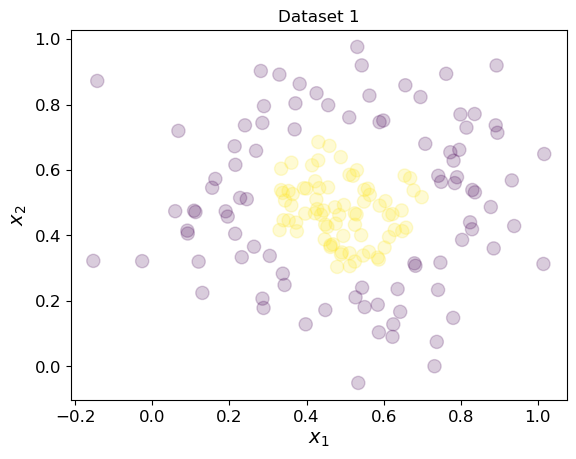

In [12]:
N = 200

xgrid = torch.arange(0,1.0,0.01)

X,Y = torch.meshgrid(xgrid, xgrid)
testgrid = torch.zeros((np.shape(xgrid)[0]**2,2))
testgrid[:,0] = X.flatten()
testgrid[:,1] = Y.flatten()


# What distribution is produced by torch.randn ?
# Try experimenting with different types of input distribution
# x = np.random.uniform(low = 0.0, high = 1.0, size= (N,2))

x = 0.2*torch.randn(N,2)+torch.tensor([0.5, 0.5])

y = ((torch.linalg.vector_norm(x-0.5, dim=1) < 0.2)*1.0).type(torch.float)  # make the class be a circle in the centre of the scene.

# cut out a border around the classes to make the task a bit more realistic
ind_incl = (torch.linalg.vector_norm(x-0.5, dim=1) > 0.25) | (torch.linalg.vector_norm(x-0.5, dim=1) < 0.20)
x = x[ind_incl,:]
y = y[ind_incl]
N = y.shape[0]
y = y.reshape(N,1)
print(N)

Ntest = 1000
xtest = 0.2*torch.randn(Ntest,2)+torch.tensor([0.5, 0.5])
ytest = ((torch.linalg.vector_norm(xtest-0.5, dim=1) < 0.2)*1.0).type(torch.float)

# cut out a border around the classes to make the task a bit more realistic
ind_incl = (torch.norm(xtest-0.5, dim=1) > 0.25) | (torch.norm(xtest-0.5, dim=1) < 0.20)
xtest = xtest[ind_incl,:]
ytest = ytest[ind_incl]

Ntest = ytest.shape[0]
ytest = ytest.reshape(Ntest,1)

plt.figure()
plt.scatter(x[:,0].numpy(),x[:,1].numpy(), alpha=0.2, s=90, cmap='viridis', c=y.view(-1))
plt.title('Dataset 1')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

---

# Define a suitable MLP or "fully-connected" model

This type of simple network can alternatively be created using the nn.Sequential container. See this [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) class page in the PyTorch documentation for an example of this.


What is the size of the input to this model? What is the size of output? Why do we have a sigmoid activation function on the output? (See the printed output.)



In [ ]:
Nhidden = 10
lamb=0.0000    # L2 weight decay term
lr = 0.01
epochs = 20000


class Net2d(nn.Module):
    def __init__(self):
        super(Net2d, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, Nhidden)
        self.fc2 = nn.Linear(Nhidden, Nhidden)
        self.fc3 = nn.Linear(Nhidden, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

net2d = Net2d()
print(net2d)

Net2d(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)


# Training the network

What type of loss are we using here? Why are we not using MSELoss ?

The type of loss being used here is Binary Cross Entropy (BCE) Loss, denoted by nn.BCELoss(). We are not using Mean Squared Error (MSE) Loss because BCE Loss is commonly used for binary classification problems where the target variable is binary, which is likely the case in this scenario. BCE Loss computes the binary cross entropy between the target and output, making it more suitable for binary classification tasks compared to MSE Loss, which is typically used for regression tasks with continuous target variables.

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.SGD(net2d.parameters(), lr=lr, momentum=0.9, weight_decay=lamb) # Note that this is adding L2 regularisation with factor lamb to every parameter

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net2d(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if epoch % 2000 == 1999:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, 0 + 1, running_loss))
        running_loss = 0.0

[2000,     1] loss: 0.097
[4000,     1] loss: 0.013
[6000,     1] loss: 0.006
[8000,     1] loss: 0.004
[10000,     1] loss: 0.003
[12000,     1] loss: 0.002
[14000,     1] loss: 0.001
[16000,     1] loss: 0.001
[18000,     1] loss: 0.001
[20000,     1] loss: 0.001


# Using the network to do prediction

Final training set loss  0.0008656687568873167
Test loss  0.003808734705671668
Percentage correct  99.76905059814453


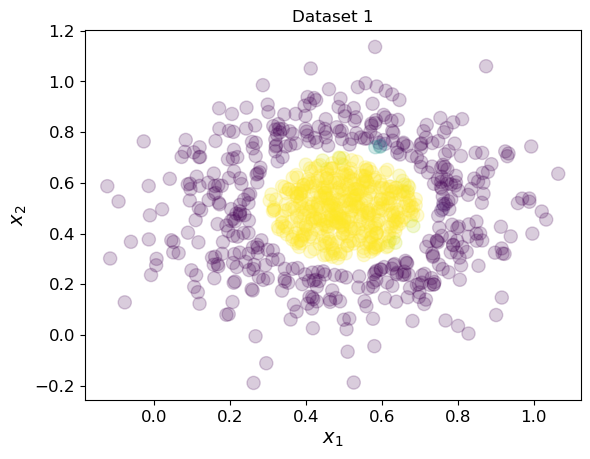

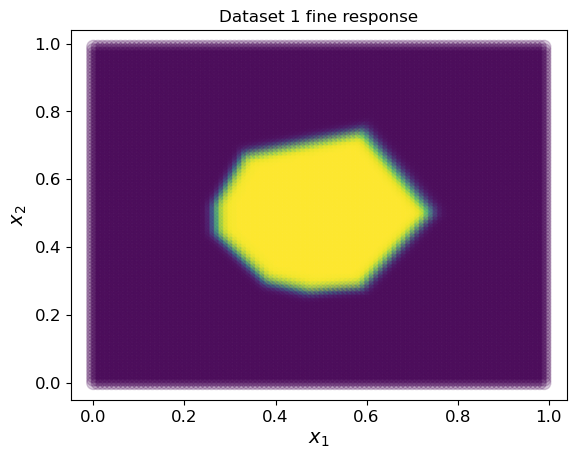

In [ ]:
pred_test = net2d(xtest)
plt.figure()
plt.scatter(xtest[:,0],xtest[:,1], alpha=0.2, s=90, cmap='viridis', c=pred_test[:,0].detach().numpy())
plt.title('Dataset 1')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

pred_testgrid = net2d(testgrid)
plt.figure()
plt.scatter(testgrid[:,0],testgrid[:,1], alpha=0.2, s=90, cmap='viridis', c=pred_testgrid[:,0].detach().numpy())
plt.title('Dataset 1 fine response')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

print('Final training set loss ', criterion(outputs, y).item())
test_loss = criterion(pred_test, ytest)
print('Test loss ', test_loss.item())
classification = torch.round(pred_test)
percentage = 100*sum(ytest.type(torch.int) == classification.type(torch.int))/Ntest
print('Percentage correct ', percentage.item())

# Experiment with the following ...

Try repeating these experiments with the following variations:
- Try with 200, 500, 2000 training points. How does that change the response of the function?
- Try changing the number of hidden units. What changes?
    - Do you see as many 'edges' on the decision boundary when using ReLUs as units? Why do you think this is?
    - Try with 1,2,3 hidden layers.
- Try with Sigmoids in the hidden layer rather than ReLUs.
    - How does that change the shape of the decision boundary? Why do you think this is?
    - How does it change the speed of error reduction?

- Try changing the loss function from Binary Cross-Entropy (`BCEloss`) to `MSEloss`. How does that affect performance? How does it affect perfomance in `mse`?
- During the above you may find that some configurations take a lot longer to reduce the error than others.


The correct choice of loss function is linked to the output type, as shown in the table below:

![output/cost function table](/home/alex/Documents/code/DL_Case_Study/Practise_labs/img/CostFunctionsOutputs.PNG)







---



# Task 3 - Classification


Let's do a classification based on the boundary that we used for regression !

---

**Dataset 2**

Text(0, 0.5, '$x_2$')

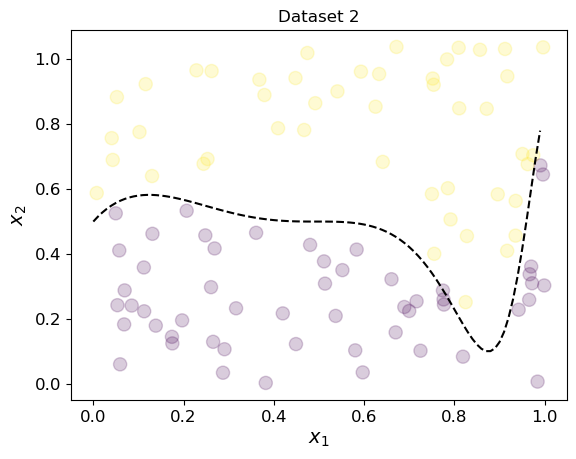

In [ ]:
N = 100   # Try 100, 500, 1000

xgrid1 = torch.arange(0,1.0,0.01)

#try experimenting with different types of input distribution
data_dist = 1 # 1 - uniform 0.5-0.5, 2 - normally distributed

if data_dist == 1:
   x = torch.rand(N,2)
else:
   x = 0.15*torch.randn(N,2)+torch.tensor([0.5, 0.5])
ind_pos = (0.5+0.4*testfunc(x[:,0]-0.5)<x[:,1])
y = (ind_pos*1.0).type(torch.float)  # lets create a classification line based on old regression function
N = y.shape[0]
y = y.reshape(N,1)
x[ind_pos,1] = x[ind_pos,1]+0.05 # create a gap between classes.


if data_dist == 1:
  xtest = torch.rand(N,2)
else:
  xtest = 0.15*torch.randn(N,2)+torch.tensor([0.5, 0.5])
ind_post = (0.5+0.4*testfunc(xtest[:,0]-0.5)<xtest[:,1])
ytest = (ind_post*1.0).type(torch.float)  # let's create a classification line based on old regression function
Ntest = ytest.shape[0]
ytest = ytest.reshape(Ntest,1)
xtest[ind_post,1] = xtest[ind_post,1]+0.05 # create a gap between classes.


plt.figure()
plt.scatter(x[:,0],x[:,1], alpha=0.2, s=90, cmap='viridis', c=y.view(-1))
plt.plot(xgrid1, 0.5+0.4*ytrue,'--k')  # show the 'true' classification line for this problem
plt.title('Dataset 2')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

# Define the model

This time we will use the Sequential container that was mentioned above to define this model.

In [ ]:
Nhidden = 10 # experiment with this
lamb=0.00
lr = 0.01
epochs = 50000


net2d = nn.Sequential(nn.Linear(2,Nhidden),
                      nn.ReLU(),
                      nn.Linear(Nhidden, Nhidden),
                      nn.ReLU(),
                      nn.Linear(Nhidden, 1),
                      nn.Sigmoid())
# reuse net2d variable. This is a more compact way of defining the network

# Train the model

Does the loss change during training? What is this telling you?

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.SGD(net2d.parameters(), lr=lr, momentum=0.9, weight_decay=lamb) # Note that this is adding L2 regularisation with factor lamb to every parameter

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net2d(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if epoch % 2000 == 1999:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, 0 + 1, running_loss))
        running_loss = 0.0

[2000,     1] loss: 0.195
[4000,     1] loss: 0.176
[6000,     1] loss: 0.158
[8000,     1] loss: 0.147
[10000,     1] loss: 0.144
[12000,     1] loss: 0.143
[14000,     1] loss: 0.142
[16000,     1] loss: 0.141
[18000,     1] loss: 0.141
[20000,     1] loss: 0.137
[22000,     1] loss: 0.115
[24000,     1] loss: 0.077
[26000,     1] loss: 0.027
[28000,     1] loss: 0.015
[30000,     1] loss: 0.010
[32000,     1] loss: 0.007
[34000,     1] loss: 0.005
[36000,     1] loss: 0.004
[38000,     1] loss: 0.003
[40000,     1] loss: 0.002
[42000,     1] loss: 0.002
[44000,     1] loss: 0.002
[46000,     1] loss: 0.002
[48000,     1] loss: 0.001
[50000,     1] loss: 0.001


# Do prediction on the test set using the model

Final training set loss  0.0011666235513985157
Test loss  0.047519341111183167
Percentage correct  99.0


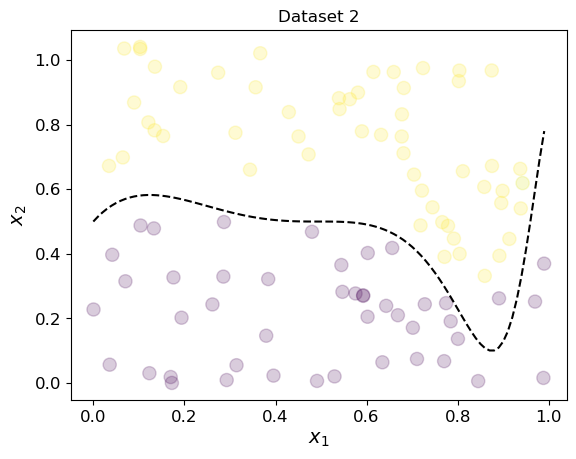

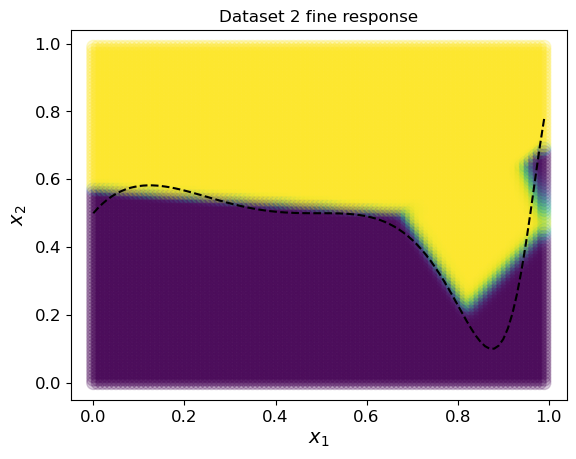

In [ ]:
pred_test = net2d(xtest)
plt.figure()
plt.scatter(xtest[:,0],xtest[:,1], alpha=0.2, s=90, cmap='viridis', c=pred_test[:,0].detach().numpy())
plt.plot(xgrid1, 0.5+0.4*ytrue,'--k')  # show the 'true' classification line for dataset2 problem
plt.title('Dataset 2')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

pred_testgrid = net2d(testgrid)
plt.figure()
plt.scatter(testgrid[:,0],testgrid[:,1], alpha=0.2, s=90, cmap='viridis', c=pred_testgrid[:,0].detach().numpy())
plt.plot(xgrid1, 0.5+0.4*ytrue,'--k')  # show the 'true' classification line for this problem
plt.title('Dataset 2 fine response')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

print('Final training set loss ', criterion(outputs, y).item())
test_loss = criterion(pred_test, ytest)
print('Test loss ', test_loss.item())
classification = torch.round(pred_test)
percentage = 100.0*torch.sum(ytest.type(torch.int) == classification.type(torch.int))/Ntest
print('Percentage correct ', percentage.item())

# Try experimenting with the following aspects of this network:

Try changing the distribution of the training data (e.g. make it normally distributed) but keeping the same classification boundary. How does that change the resulting classification boundary?

Try with N= 100, 500, 1000 training examples with linearly distribute and normally distributed data. What is this telling you?

Try different sizes of network to see what differences result.

What happens with small training sets and large networks?